# Solving MOO with SMT Toolkit

The surrogate modeling toolbox (SMT) is a Python package that contains a collection of surrogate modeling methods, sampling techniques, and benchmarking functions. This package provides a library of surrogate models that is simple to use and facilitates the implementation of additional methods.

SMT is different from existing surrogate modeling libraries because of its emphasis on derivatives, including training derivatives used for gradient-enhanced modeling, prediction derivatives, and derivatives with respect to the training data.

In [ ]:
!pip install -q smt

This tutorial describes how to use the SMT toolbox to do some Bayesian Optimization (EGO method) to solve unconstrained optimization problem.

In this section, two examples are presented to illustrate Bayesian Optimization
- a 1D-example (xsinx function) where the algorithm is explicitely given and the use of different criteria is presented
- a 2D-exemple (Rosenbrock function) where the EGO algorithm from SMT is used  

## Bayesian Optimization 

In [23]:
%matplotlib inline

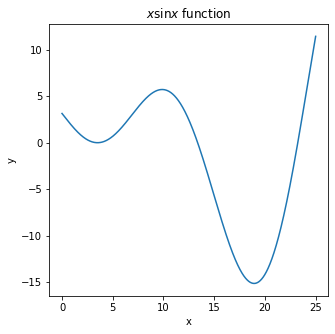

In [24]:
import numpy as np 
import matplotlib.pyplot as plt

plt.ion()

def fun(point):
    return np.atleast_2d((point-3.5)*np.sin((point-3.5)/(np.pi)))

X_plot = np.atleast_2d(np.linspace(0, 25, 10000)).T
Y_plot = fun(X_plot)


lines = []
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
lines.append(true_fun)
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

#dimension of the problem 
ndim = 1 

Here, the training data are the points xdata=[0,7,25]. 


In [25]:
x_data = np.atleast_2d([0,7,25]).T
y_data = fun(x_data)

Build the GP model with a square exponential kernel with SMT toolbox knowing $(x_{data}, y_{data})$.

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0915842


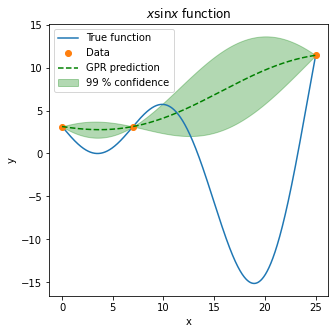

In [26]:
from smt.surrogate_models import KPLS, KRG, KPLSK

########### The Kriging model

# The variable 'theta0' is a list of length ndim.
t = KRG(theta0=[1e-2]*ndim,print_prediction = False, corr='squar_exp')

#Training
t.set_training_values(x_data,y_data)
t.train()



# Prediction of the  points for the plot
Y_GP_plot = t.predict_values(X_plot)
Y_GP_plot_var = t.predict_variances(X_plot)
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot,linestyle='--',color='g')
sig_plus = Y_GP_plot+3*np.sqrt(Y_GP_plot_var)
sig_moins = Y_GP_plot-3*np.sqrt(Y_GP_plot_var)
un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
lines = [true_fun,data,gp,un_gp]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data','GPR prediction','99 % confidence'])
plt.show()

Bayesian optimization is defined by Jonas Mockus in (Mockus, 1975) as an optimization technique based upon the minimization of the expected deviation from the extremum of the studied function. 

The objective function is treated as a black-box function. A Bayesian strategy sees the objective as a random function and places a prior over it. The prior captures our beliefs about the behavior of the function. After gathering the function evaluations, which are treated as data, the prior is updated to form the posterior distribution over the objective function. The posterior distribution, in turn, is used to construct an acquisition function (often also referred to as infill sampling criterion) that determines what the next query point should be.

One of the earliest bodies of work on Bayesian optimisation that we are aware of is (Kushner, 1962 ; Kushner, 1964). Kushner used Wiener processes for one-dimensional problems. Kushner’s decision model was based on maximizing the probability of improvement, and included a parameter that controlled the trade-off between ‘more global’ and ‘more local’ optimization, in the same spirit as the Exploration/Exploitation trade-off.

Meanwhile, in the former Soviet Union, Mockus and colleagues developed a multidimensional Bayesian optimization method using linear combinations of Wiener fields, some of which was published in English in (Mockus, 1975). This paper also describes an acquisition function that is based on myopic expected improvement of the posterior, which has been widely adopted in Bayesian optimization as the Expected Improvement function.

In 1998, Jones used Gaussian processes together with the expected improvement function to successfully perform derivative-free optimization and experimental design through an algorithm called  Efficient  Global  Optimization, or EGO (Jones, 1998).



### Efficient Global Optimization

In what follows, we describe the Efficient Global Optimization (EGO) algorithm, as published in (Jones, 1998).

Let $F$ be an expensive black-box function to be minimized. We sample $F$ at the different locations  $X = \{x_1, x_2,\ldots,x_n\}$ yielding the responses $Y = \{y_1, y_2,\ldots,y_n\}$. We build a Kriging model (also called Gaussian process) with a mean function $\mu$ and a variance function $\sigma^{2}$.

The next step is to compute the criterion EI. To do this, let us denote:
$$f_{min} = \min \{y_1, y_2,\ldots,y_n\}.$$
The Expected Improvement funtion (EI) can be expressed:
$$E[I(x)] = E[\max(f_{min}-Y, 0)],$$
where $Y$ is the random variable following the distribution $\mathcal{N}(\mu(x), \sigma^{2}(x))$.
By expressing the right-hand side of EI expression as an integral, and applying some tedious integration by parts, one can express the expected improvement in closed form: 
$$
E[I(x)] = (f_{min} - \mu(x))\Phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right) + \sigma(x) \phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right)
$$
where $\Phi(\cdot)$ and $\phi(\cdot)$ are respectively the cumulative and probability density functions of $\mathcal{N}(0,1)$.

Next, we determine our next sampling point as :
\begin{align}
x_{n+1} = \arg \max_{x} \left(E[I(x)]\right)
\end{align}

We then test the response $y_{n+1}$ of our black-box function $F$ at $x_{n+1}$, rebuild the model taking into account the new information gained, and research the point of maximum expected improvement again.

We summarize here the EGO algorithm:

EGO(F, $n_{iter}$) \# Find the best minimum of $\operatorname{F}$ in $n_{iter}$ iterations  
For ($i=0:n_{iter}$)  

* $mod = {model}(X, Y)$  \# surrogate model based on sample vectors $X$ and $Y$  
* $f_{min} = \min Y$  
* $x_{i+1} = \arg \max {EI}(mod, f_{min})$ \# choose $x$ that maximizes EI  
* $y_{i+1} = {F}(x_{i+1})$ \# Probe the function at most promising point $x_{i+1}$  
* $X = [X,x_{i+1}]$  
* $Y = [Y,y_{i+1}]$   
* $i = i+1$  

$f_{min} = \min Y$  
Return : $f_{min}$ \# This is the best known solution after $n_{iter}$ iterations

Now we want to optimize this function by using Bayesian Optimization and comparing
- Surrogate Based optimization (SBO)
- Expected Improvement criterion (EI)


In a first step we compute the EI criterion

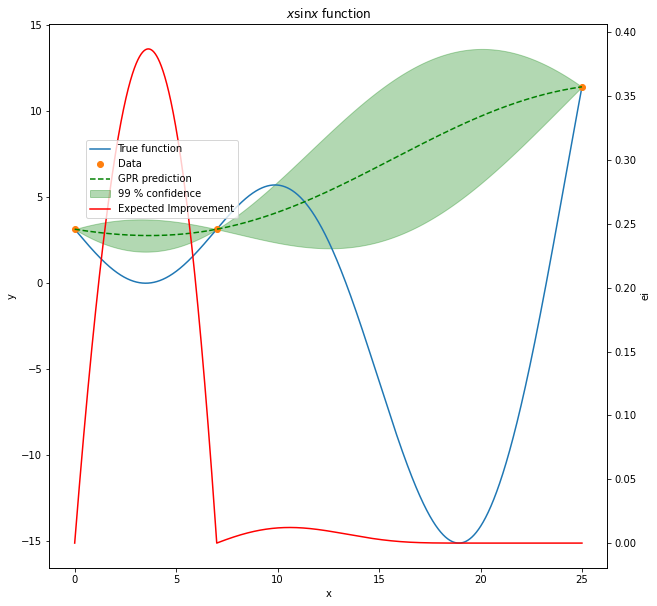

In [27]:
from scipy.stats import norm
from scipy.optimize import minimize

def EI(GP,points,f_min):
    pred = GP.predict_values(points)
    var = GP.predict_variances(points)
    args0 = (f_min - pred)/np.sqrt(var)
    args1 = (f_min - pred)*norm.cdf(args0)
    args2 = np.sqrt(var)*norm.pdf(args0)

    if var.size == 1 and var == 0.0:  # can be use only if one point is computed
        return 0.0
   
    
    ei = args1 + args2
    return ei


Y_GP_plot = t.predict_values(X_plot)
Y_GP_plot_var  =  t.predict_variances(X_plot)
Y_EI_plot = EI(t,X_plot,np.min(y_data))

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot,linestyle='--',color='g')
sig_plus = Y_GP_plot+3*np.sqrt(Y_GP_plot_var)
sig_moins = Y_GP_plot-3*np.sqrt(Y_GP_plot_var)
un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
ax1 = ax.twinx()
ei, = ax1.plot(X_plot,Y_EI_plot,color='red')
lines = [true_fun,data,gp,un_gp,ei]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax1.set_ylabel('ei')
fig.legend(lines,['True function','Data','GPR prediction','99 % confidence','Expected Improvement'],loc=[0.13,0.64])
plt.show()

Now we compute the EGO method and compare it to other infill criteria 
- SBO (surrogate based optimization): directly using the prediction of the surrogate model ($\mu$)
- LCB (Lower Confidence bound): using the confidence interval : $\mu -3 \times \sigma$
- EI for expected Improvement (EGO)

In [28]:
#surrogate Based optimization: min the Surrogate model by using the mean mu
def SBO(GP,point):
    res = GP.predict_values(point)
    return res

#lower confidence bound optimization: minimize by using mu - 3*sigma
def LCB(GP,point):
    pred = GP.predict_values(point)
    var = GP.predict_variances(point)
    res = pred-3.*np.sqrt(var)
    return res

In [29]:
IC = 'EI'

In [14]:
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML


plt.ioff()

x_data = np.atleast_2d([0,7,25]).T
y_data = fun(x_data)

n_iter = 15

gpr = KRG(theta0=[1e-2]*ndim,print_global = False)


for k in range(n_iter):
    x_start = np.atleast_2d(np.random.rand(20)*25).T
    f_min_k = np.min(y_data)
    gpr.set_training_values(x_data,y_data)
    gpr.train()
    if IC == 'EI':
        obj_k = lambda x: -EI(gpr,np.atleast_2d(x),f_min_k)[:,0]
    elif IC =='SBO':
        obj_k = lambda x: SBO(gpr,np.atleast_2d(x))
    elif IC == 'LCB':
        obj_k = lambda x: LCB(gpr,np.atleast_2d(x))
    
    opt_all = np.array([minimize(lambda x: float(obj_k(x)), x_st, method='SLSQP', bounds=[(0,25)]) for x_st in x_start])
    opt_success = opt_all[[opt_i['success'] for opt_i in opt_all]]
    obj_success = np.array([opt_i['fun'] for opt_i in opt_success])
    ind_min = np.argmin(obj_success)
    opt = opt_success[ind_min]
    x_et_k = opt['x']
    
    y_et_k = fun(x_et_k)
    
    y_data = np.atleast_2d(np.append(y_data,y_et_k)).T
    x_data = np.atleast_2d(np.append(x_data,x_et_k)).T
    
    Y_GP_plot = gpr.predict_values(X_plot)
    Y_GP_plot_var  =  gpr.predict_variances(X_plot)
    Y_EI_plot = -EI(gpr,X_plot,f_min_k)

    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(111)
    if IC == 'LCB' or IC == 'SBO':
        ei, = ax.plot(X_plot,Y_EI_plot,color='red')
    else:    
        ax1 = ax.twinx()
        ei, = ax1.plot(X_plot,Y_EI_plot,color='red')
    true_fun, = ax.plot(X_plot,Y_plot)
    data, = ax.plot(x_data[0:k+3],y_data[0:k+3],linestyle='',marker='o',color='orange')
    opt, = ax.plot(x_data[k+3],y_data[k+3],linestyle='',marker='*',color='r')
    gp, = ax.plot(X_plot,Y_GP_plot,linestyle='--',color='g')
    sig_plus = Y_GP_plot+3*np.sqrt(Y_GP_plot_var)
    sig_moins = Y_GP_plot-3*np.sqrt(Y_GP_plot_var)
    un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
    lines = [true_fun,data,gp,un_gp,opt,ei]
    ax.set_title('$x \sin{x}$ function')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(lines,['True function','Data','GPR prediction','99 % confidence','Next point to Evaluate','Infill Criteria'])
    plt.savefig('Optimisation %d' %k)
    plt.close(fig)
    
ind_best = np.argmin(y_data)
x_opt = x_data[ind_best]
y_opt = y_data[ind_best]

print('Results : X = %s, Y = %s' %(x_opt,y_opt))

fig = plt.figure(figsize=[10,10])

ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ims = []
for k in range(n_iter):
    image_pt = mpimg.imread('Optimisation %d.png' %k)
    im = plt.imshow(image_pt)
    ims.append([im])
    
ani = animation.ArtistAnimation(fig, ims,interval=500)
HTML(ani.to_jshtml())

Results : X = [18.94814693], Y = [-15.12496433]


### Use the EGO from SMT 

In [15]:
from smt.applications.ego import EGO
from smt.sampling_methods import LHS

* Choose your criterion to perform the optimization: EI, SBO or LCB
* Choose the size of the initial DOE
* Choose the number of EGO iterations

### Try with a 2D function : 2D Rosenbrock function 

Rosenbrock Function  in dimension N

$$
f(\mathbf{x}) = \sum_{i=1}^{N-1} 100 (x_{i+1} - x_i^2 )^2 + (1-x_i)^2 \quad \mbox{where} \quad \mathbf{x} = [x_1, \ldots, x_N] \in \mathbb{R}^N.
$$

$$x_i \in [-2,2]$$

In [30]:
#define the rosenbrock function
def rosenbrock(x):
    """
    Evaluate objective and constraints for the Rosenbrock test case:
    """
    n,dim = x.shape

    #parameters:
    Opt =[]
    Opt_point_scalar = 1
    #construction of O vector
    for i in range(0, dim):
        Opt.append(Opt_point_scalar)

    #Construction of Z vector
    Z= np.zeros((n,dim))
    for i in range(0,dim):
        Z[:,i] = (x[:,i]-Opt[i]+1)

    #Sum
    sum1 = np.zeros((n,1))
    for i in range(0,dim-1):
        sum1[:,0] += 100*(((Z[:,i]**2)-Z[:,i+1])**2)+((Z[:,i]-1)**2)

    return sum1


xlimits=np.array([[-2,2], [-2,2]])

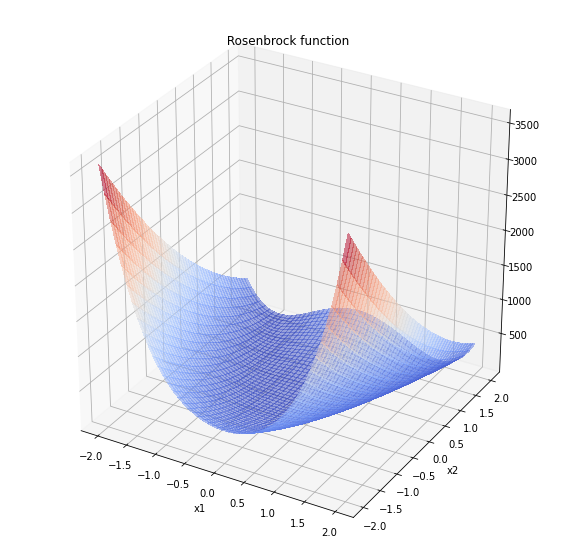

In [31]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

#To plot the Rosenbrock function
num_plot = 50 #to plot rosenbrock
x = np.linspace(xlimits[0][0],xlimits[0][1],num_plot)
res = []
for x0 in x:
    for x1 in x:
        res.append(rosenbrock(np.array([[x0,x1]])))
res = np.array(res)
res = res.reshape((50,50)).T
X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, res, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=0.5)
plt.title(' Rosenbrock function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [32]:
criterion='EI' #'EI' or 'SBO' or 'LCB'

#number of points in the initial DOE
ndoe = 10 #(at least ndim+1)

#number of iterations with EGO 
n_iter = 50

#Build the initial DOE, add the random_state option to have the reproducibility of the LHS points
sampling = LHS(xlimits=xlimits, random_state=1)
xdoe = sampling(ndoe)

#EGO call
ego = EGO(n_iter=n_iter, criterion=criterion, xdoe=xdoe, xlimits=xlimits)

x_opt, y_opt, ind_best, x_data, y_data = ego.optimize(fun=rosenbrock)

print('Xopt for Rosenbrock ', x_opt,y_opt, ' obtained using EGO criterion = ', criterion )
print('Check if the optimal point is Xopt= (1,1) with the Y value=0')
print('if not you can increase the number of iterations with n_iter but the CPU will increase also.')
print('---------------------------')

Xopt for Rosenbrock  [0.95199187 0.92363401] [0.03239142]  obtained using EGO criterion =  EI
Check if the optimal point is Xopt= (1,1) with the Y value=0
if not you can increase the number of iterations with n_iter but the CPU will increase also.
---------------------------


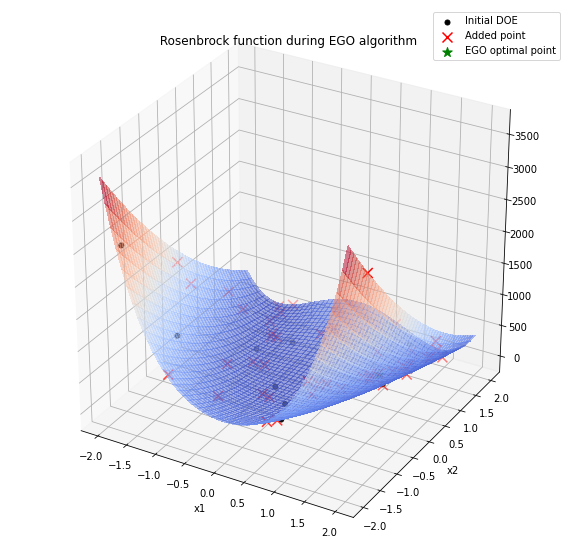

In [34]:
#To plot the Rosenbrock function
#3D plot
x = np.linspace(xlimits[0][0],xlimits[0][1],num_plot)
res = []
for x0 in x:
    for x1 in x:
        res.append(rosenbrock(np.array([[x0,x1]])))
res = np.array(res)
res = res.reshape((50,50)).T
X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, res, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=0.5)
#to add the points provided by EGO
ax.scatter(x_data[:ndoe,0],x_data[:ndoe,1],y_data[:ndoe],zdir='z',marker = '.',c='k',s=100, label='Initial DOE')
ax.scatter(x_data[ndoe:,0],x_data[ndoe:,1],y_data[ndoe:],zdir='z',marker = 'x',c='r', s=100, label= 'Added point')
ax.scatter(x_opt[0],x_opt[1],y_opt,zdir='z',marker = '*',c='g', s=100, label= 'EGO optimal point')

plt.title(' Rosenbrock function during EGO algorithm')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

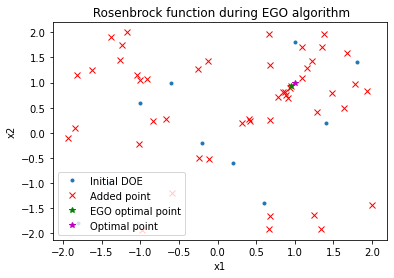

In [33]:
#2D plot 
#to add the points provided by EGO
plt.plot(x_data[:ndoe,0],x_data[:ndoe,1],'.', label='Initial DOE')
plt.plot(x_data[ndoe:,0],x_data[ndoe:,1],'x', c='r', label='Added point')
plt.plot(x_opt[:1],x_opt[1:],'*',c='g', label= 'EGO optimal point')
plt.plot([1], [1],'*',c='m', label= 'Optimal point')

plt.title(' Rosenbrock function during EGO algorithm')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

We can now compare the results by using only the mean information provided by surrogate model approximation


In [20]:
criterion='SBO' #'EI' or 'SBO' or 'LCB'

#number of points in the initial DOE
ndoe = 10 #(at least ndim+1)

#number of iterations with EGO 
n_iter = 50

#Build the initial DOE
sampling = LHS(xlimits=xlimits, random_state=1)
xdoe = sampling(ndoe)


#EGO call
ego = EGO(n_iter=n_iter, criterion=criterion, xdoe=xdoe, xlimits=xlimits)

x_opt, y_opt, ind_best, x_data, y_data = ego.optimize(fun=rosenbrock)

print('Xopt for Rosenbrock ', x_opt, y_opt, ' obtained using EGO criterion = ', criterion)
print('Check if the optimal point is Xopt=(1,1) with the Y value=0')
print('---------------------------')

Xopt for Rosenbrock  [0.98232365 0.96610171] [0.00044286]  obtained using EGO criterion =  SBO
Check if the optimal point is Xopt=(1,1) with the Y value=0
---------------------------


## Mixed Integer EGO

This section describes how to perform a mixed optimization using the SMT toolbox. The idea is to use a Bayesian Optimization (EGO method) to solve an unconstrained optimization problem with mixed variables.

For mixed integer EGO, the model is the continuous one. The discrete variables being relaxed continuously

In [35]:
from math import exp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.optimize import minimize
import scipy
import six
from smt.applications import EGO
from smt.surrogate_models import KRG
from smt.sampling_methods import FullFactorial
from smt.sampling_methods import LHS
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
import matplotlib.font_manager
from smt.applications.mixed_integer import MixedIntegerSurrogateModel

import warnings
warnings.filterwarnings("ignore")

from smt.applications.mixed_integer import (
    FLOAT,
    ORD,
    ENUM,
    MixedIntegerSamplingMethod,
    cast_to_mixed_integer, unfold_with_enum_mask
)

Definition of the plot function 

In [ ]:
def PlotEgo(criterion, xdoe, bounds,npt,n_iter=12,xtypes=None, sm=KRG(print_global=False)) :
    ego = EGO(n_iter=n_iter, criterion=criterion, xdoe=xdoe,xtypes=xtypes, xlimits=bounds,n_start=20,n_max_optim=35,enable_tunneling=False, surrogate=sm)
    x_opt, y_opt, ind_best, x_data, y_data = ego.optimize(fun=f)
    print("Minimum in x={:.0f} with f(x)={:.10f}".format(int(x_opt), float(y_opt)))

    x_plot = np.atleast_2d(np.linspace(bounds[0][0], bounds[0][1], 9*(npt-1)+1)).T
    fig = plt.figure(figsize=[15, 15])
    for i in range(n_iter):
        k = n_doe + i
        x_data_k = x_data[0:k]
        y_data_k = y_data[0:k]
        
            #if check list, not already evaluated
        y_data[k]=f(x_data[k][:, np.newaxis])
        ego.gpr.set_training_values(x_data_k, y_data_k)
        ego.gpr.train()
        y_gp_plot = ego.gpr.predict_values(x_plot)
        y_gp_plot_var = ego.gpr.predict_variances(x_plot)
        y_ei_plot = ego.EI(x_plot,y_data_k)
        ax = fig.add_subplot((n_iter + 1) // 2, 2, i + 1)
        ax1 = ax.twinx()
        ei, = ax1.plot(x_plot, y_ei_plot, color="red")

        true_fun = ax.scatter(Xsol, Ysol,color='k',marker='d')
        data, = ax.plot(
            x_data_k, y_data_k, linestyle="", marker="o", color="orange"
        )
        if i < n_iter - 1:
            opt, = ax.plot(
                x_data[k], y_data[k], linestyle="", marker="*", color="r"
            )
            print(x_data[k], y_data[k])
        gp, = ax.plot(x_plot, y_gp_plot, linestyle="--", color="g")        
        sig_plus = y_gp_plot + 3 * np.sqrt(y_gp_plot_var)
        sig_moins = y_gp_plot - 3 * np.sqrt(y_gp_plot_var)
        un_gp = ax.fill_between(
            x_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
        )
        lines = [true_fun, data, gp, un_gp, opt, ei]
        fig.suptitle("EGO optimization of a set of points")
        fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.8)
        ax.set_title("iteration {}".format(i + 1))
        fig.legend(
            lines,
            [
                "set of points",
                "Given data points",
                "Kriging prediction",
                "Kriging 99% confidence interval",
                "Next point to evaluate",
                "Expected improvment function",
            ],
        )
    plt.show()

### Local minimum trap: 1D function 
 The 1D function to optimize is described by: 
- 1 discrete variable $\in [0, 25]$

In [ ]:
#definition of the 1D function
def f(X) :
    x= X[:, 0]
    if (np.abs(np.linalg.norm(np.floor(x))-np.linalg.norm(x))< 0.000001):
        y = (x - 3.5) * np.sin((x - 3.5) / (np.pi))
    else :
        print("error")
    return y

Min of the DOE:  -15.121611536143384


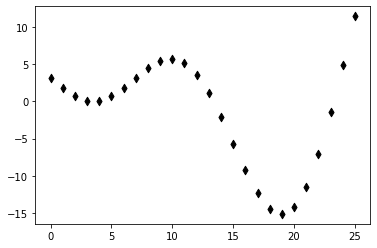

In [ ]:
#to plot the function
bounds = np.array([[0, 25]])
npt=26

Xsol = np.linspace(bounds[0][0],bounds[0][1], npt)
Xs= Xsol[:, np.newaxis]
Ysol = f(Xs)
print("Min of the DOE: ",np.min(Ysol)) 
plt.scatter(Xs,Ysol,marker='d',color='k')
plt.show()

Minimum in x=19 with f(x)=-15.1216115361
[1.] [1.78601478]
[2.] [0.68929352]
[3.] [0.07924194]
[25.] [11.42919546]
[17.] [-12.35295142]
[19.] [-15.12161154]
[20.] [-14.15453288]
[21.] [-11.44370682]
[19.] [-15.12161154]


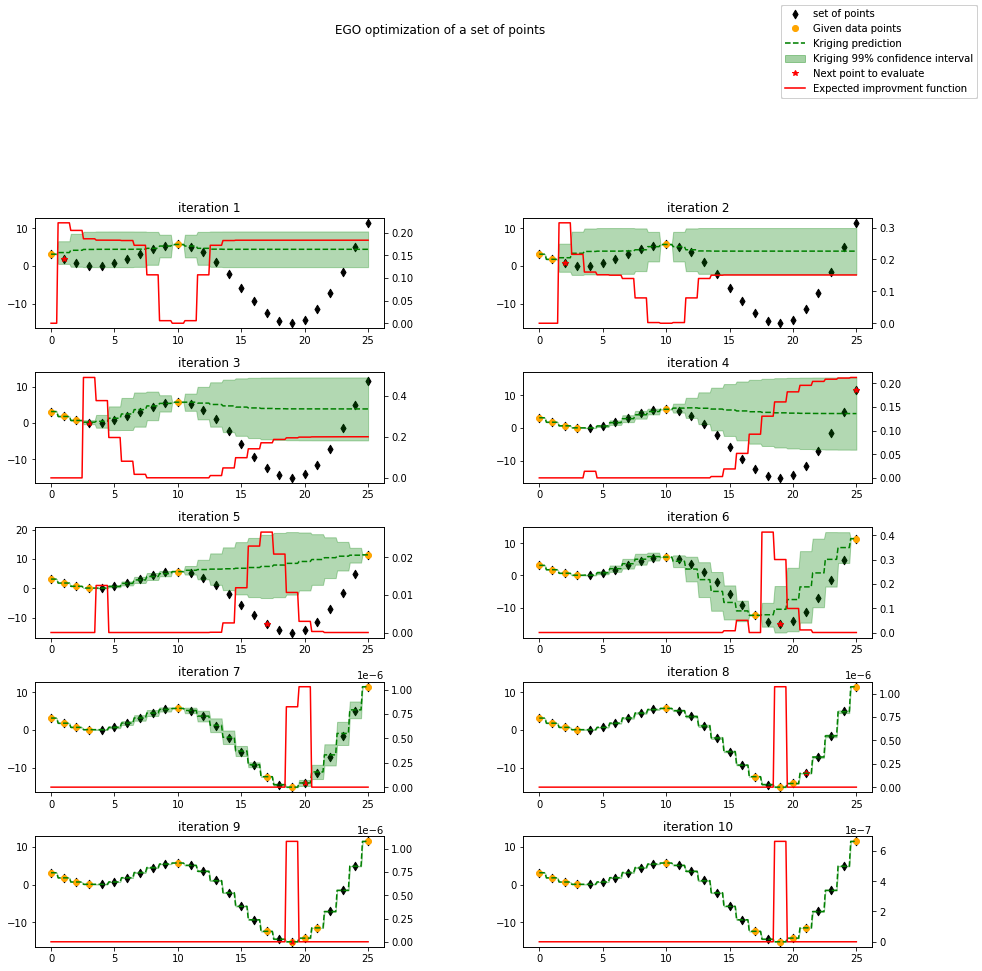

In [ ]:
#to run the optimization process
n_iter = 10
xdoe = np.atleast_2d([0,10]).T
n_doe = xdoe.size
xtypes=[ORD]
criterion = "EI"  #'EI' or 'SBO' or 'LCB'
PlotEgo(criterion,xdoe,bounds,npt,n_iter,xtypes=xtypes)

On this 1D test case, 4 iterations are required to find the global minimum, evaluated at iteration 5.

### 1D function with noisy values
 The 1D function to optimize is described by: 
- 1 discrete variable $\in [0, 60]$

In [ ]:
def f(X) :
    x= X[:, 0]
    y = -np.square(x-25)/220+0.25*(np.sin((x - 3.5) * np.sin((x - 3.5) / (np.pi)))+np.cos(x**2))
    np.random.seed(10)
    y2 = y+3*np.random.uniform(size=y.shape)
    return -y2

min of the DOE:  -2.6466034697899508


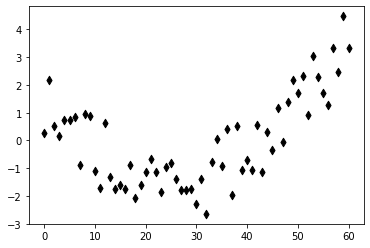

In [ ]:
#to plot the function
xlimits = np.array([[0, 60]])
npt=61


Xsol = np.linspace(xlimits[0][0],xlimits[0][1], npt)
Xs= Xsol[:, np.newaxis]

Ysol = f(Xs)



print("min of the DOE: ", np.min(Ysol))
plt.scatter(Xs,Ysol,marker='d',color='k')
plt.show()

Minimum in x=27 with f(x)=-2.5711544528
[39.] [-1.48693582]
[57.] [2.38327783]
[2.] [0.09499639]
[30.] [-2.17774225]
[31.] [-2.14085009]
[27.] [-2.57115445]
[24.] [-1.94863943]
[47.] [0.29522575]
[28.] [-2.16068891]


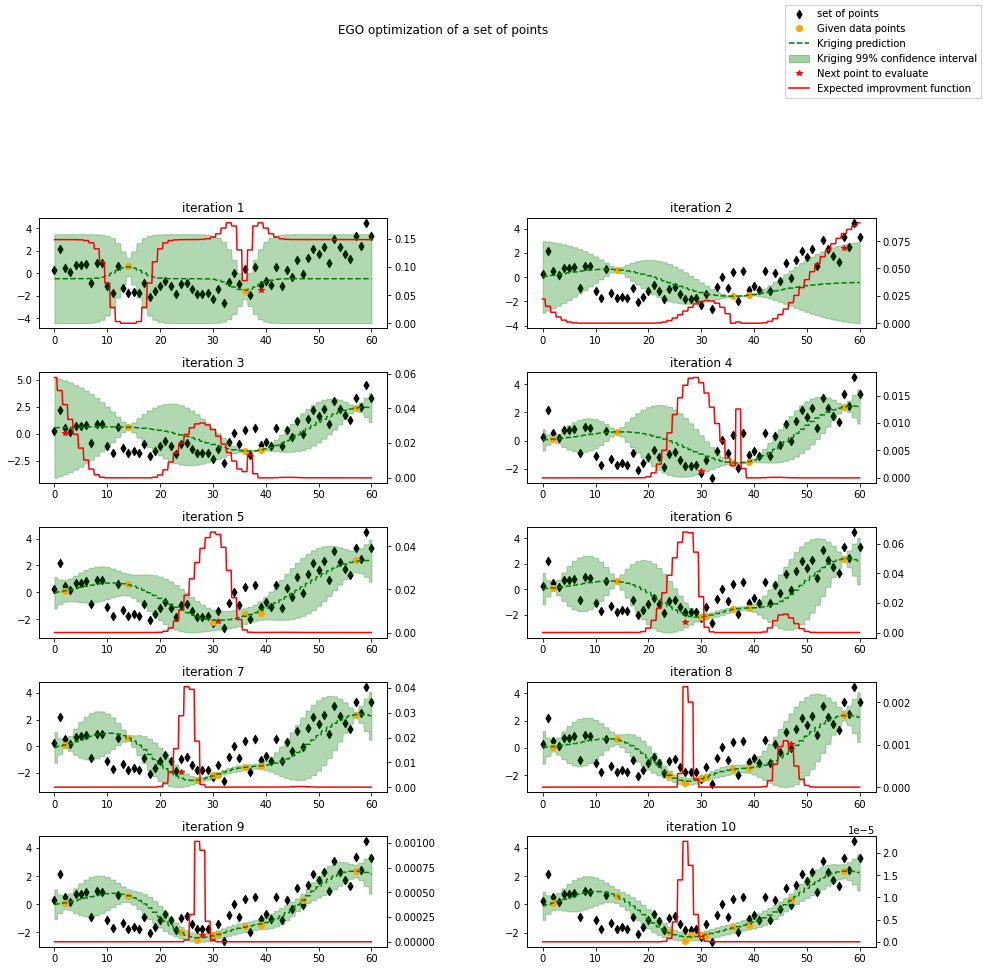

In [ ]:
#to run the optimization process
n_iter = 10
n_doe=2
sampling = MixedIntegerSamplingMethod(xtypes, xlimits, LHS, criterion="ese")
xdoe = sampling(n_doe)
xtypes=[ORD]
criterion = "EI"  #'EI' or 'SBO' or 'LCB'
sm=KRG(print_global=False,eval_noise= True)
PlotEgo(criterion,xdoe,xlimits,npt,n_iter,xtypes,sm=sm)

- On this noisy case, it toook 7 iterations to understand the shape of the curve but then, it took time to explore the random noise aroudn the minimum.

### 2D mixed branin function
The 2D function to optimize is described by: 
- 1 discrete variable $\in [-5, 10]$
- 1 continuous variable $\in [0., 15.]$

In [ ]:
#definition of the 2D function
#the first variable is a integer one and the second one is a continuous one
import math
def f(X) :
    x1 = X[:,0]
    x2 = X[:,1]
    PI = math.pi #3.14159265358979323846
    a = 1
    b = 5.1/(4*np.power(PI,2))
    c = 5/PI
    r = 6   
    s = 10
    t = 1/(8*PI)
    y=  a*(x2 - b*x1**2 + c*x1 -r)**2 + s*(1-t)*np.cos(x1) + s
    return y

In [ ]:
#to define and compute the doe 
xtypes = [ORD, FLOAT]
xlimits = np.array([[-5.0, 10.0],[0.0,15.0]])
n_doe=20
sampling = MixedIntegerSamplingMethod(xtypes, xlimits, LHS, criterion="ese")
xt = sampling(n_doe)
yt = f(xt)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 10000
   
   Predicting ...
   Predicting - done. Time (sec):  0.0212641
   
   Prediction time/pt. (sec) :  0.0000021
   


Text(0.5, 1.0, 'surrogate mean response')

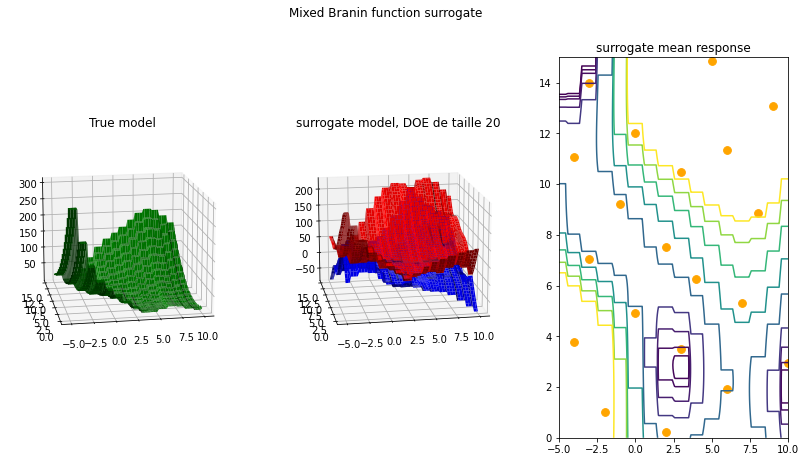

In [ ]:
#to build the mixed surrogate model
sm = MixedIntegerSurrogateModel(xtypes=xtypes, xlimits=xlimits, surrogate=KRG())
sm.set_training_values(xt, yt)
sm.train()

num = 100
x = np.linspace(-5.0,10., 100)
y = np.linspace(0,15., 100)
xv, yv = np.meshgrid(x, y)
x_plot= np.array([np.ravel(xv), np.ravel(yv)]).T
y_plot = f(np.floor(x_plot))

fig = plt.figure(figsize=[14, 7])

y_gp_plot = sm.predict_values(x_plot)
y_gp_plot_sd = np.sqrt(sm.predict_variances(x_plot))
l=y_gp_plot-3*y_gp_plot_sd
h=y_gp_plot+3*y_gp_plot_sd
ax =  fig.add_subplot(1, 3, 1, projection='3d')
ax1 = fig.add_subplot(1, 3, 2, projection='3d') 
ax2 = fig.add_subplot(1, 3,3)  

ii=-100
ax.view_init(elev=15., azim=ii)
ax1.view_init(elev=15., azim=ii)

true_fun = ax.plot_surface(xv, yv, y_plot.reshape((100, 100)), label ='true_function',color='g')
data3 = ax2.scatter(xt.T[0],xt.T[1],s=60,marker="o",color="orange")
gp1 = ax1.plot_surface(xv, yv, l.reshape((100, 100)), color="b")
gp2 = ax1.plot_surface(xv, yv, h.reshape((100, 100)), color="r")  
gp3 = ax2.contour(xv, yv, y_gp_plot.reshape((100, 100)), color="k", levels=[0,1,2,5,10,20,30,40,50,60])
fig.suptitle("Mixed Branin function surrogate")
ax.set_title("True model")
ax1.set_title("surrogate model, DOE de taille {}".format(n_doe))
ax2.set_title("surrogate mean response")

- On the left, we have the real model in green.  
- In the middle we have the mean surrogate $+3\times \mbox{ standard deviation}$ (red) and the mean surrogate $-3\times \mbox{ standard deviation}$  (blue) in order to represent an approximation of the $99\%$ confidence interval.

- On the right, the contour plot of the mean surrogate are given where yellow points are the values at the evaluated points (DOE).

### 4D mixed test case

The 4D function to optimize is described by: 
- 1 continuous variable $\in [-5, 5]$
- 1 categorical variable with 3 labels $["blue", "red", "green"]$
- 1 categorical variable with 2 labels $ ["large", "small"]$ 
- 1 discrete variable $\in [0, 2]$

Initial DOE: 
 xdoe =  [[-4.78881336  0.          0.          1.        ]
 [ 0.3765851   1.          1.          1.        ]] 
 ydoe =  [-3.78881336  1.7155117 ]


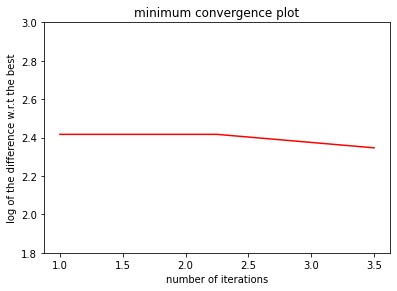

In [ ]:
#to define the 4D function 
def function_test_mixed_integer(X):
    import numpy as np

    # float
    x1 = X[:, 0]
    #  enum 1
    c1 = X[:, 1]
    x2 = c1 == 0
    x3 = c1 == 1
    x4 = c1 == 2
    #  enum 2
    c2 = X[:, 2]
    x5 = c2 == 0
    x6 = c2 == 1
    # int
    i = X[:, 3]

    y = (
        (x2 + 2 * x3 + 3 * x4) * x5 * x1
        + (x2 + 2 * x3 + 3 * x4) * x6 * 0.95 * x1
        + i
    )
    return y
#to run the optimization process
n_iter = 15
xtypes = [FLOAT, (ENUM, 3), (ENUM, 2), ORD]
xlimits = np.array([[-5, 5], ["blue", "red", "green"], ["large", "small"], [0, 2]])
criterion = "EI"  #'EI' or 'SBO' or 'LCB'
qEI = "KB"
sm = KRG(print_global=False)

n_doe = 3
sampling = MixedIntegerSamplingMethod(xtypes, xlimits, LHS, criterion="ese")
xdoe = sampling(n_doe)
ydoe = function_test_mixed_integer(xdoe)
print('Initial DOE: \n', 'xdoe = ',xdoe, '\n ydoe = ',ydoe)

ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    ydoe=ydoe,
    xtypes=xtypes,
    xlimits=xlimits,
    surrogate=sm,
    qEI=qEI,
)

x_opt,y_opt, _, _, y_data = ego.optimize(fun=function_test_mixed_integer)

#to plot the objective function during the optimization process
min_ref = -15
mini = np.zeros(n_iter)
for k in range(n_iter):
    mini[k] = np.log(np.abs(np.min(y_data[0 : k + n_doe - 1]) - min_ref))
x_plot = np.linspace(1, n_iter + 0.5, n_iter)
u = max(np.floor(max(mini)) + 1, -100)
l = max(np.floor(min(mini)) - 0.2, -10)
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(x_plot, mini, color="r")
axes.set_ylim([l, u])
plt.title("minimum convergence plot", loc="center")
plt.xlabel("number of iterations")
plt.ylabel("log of the difference w.r.t the best")
plt.show()



In [ ]:
print(" 4D EGO Optimization: Minimum in x=",cast_to_mixed_integer(xtypes, xlimits, x_opt), "with y value =",y_opt)

 4D EGO Optimization: Minimum in x= [-4.787901399915533, 'blue', 'small', 0] with y value = [-4.54850633]


### Manipulate the DOE

In [ ]:
#to give the initial doe in the initial space
print('Initial DOE in the initial space: ')
for i in range(n_doe):
    print("Doe point  i={} ={}".format((i), (cast_to_mixed_integer(xtypes, xlimits, xdoe[i]))),'\n')
    
#to give the initial doe in the relaxed space
print('Initial DOE in the unfold space (or relaxed space): ')
for i in range(n_doe):
    print("Doe point  i={} ={}".format((i), (unfold_with_enum_mask(xtypes,  xdoe[i]))),'\n')
    
#to print the used DOE
print('Initial DOE in the fold space: ')
for i in range(n_doe):
    print("Doe point  i={} ={}".format((i), xdoe[i]),'\n')

Initial DOE in the initial space: 
Doe point  i=0 =[4.364426817509299, 'blue', 'large', 2] 

Doe point  i=1 =[-0.18798670077652702, 'green', 'small', 1] 

Initial DOE in the unfold space (or relaxed space): 
Doe point  i=0 =[[4.36442682 1.         0.         0.         1.         0.
  2.        ]] 

Doe point  i=1 =[[-0.1879867  0.         0.         1.         0.         1.
   1.       ]] 

Initial DOE in the fold space: 
Doe point  i=0 =[4.36442682 0.         0.         2.        ] 

Doe point  i=1 =[-0.1879867  2.         1.         1.       ] 



### Gower mixed based surrogate model 2D function 

The function is described by: 
- 1 continuous variable $\in [0, 4]$
- 1 categorical variable with 2 labels $["Blue", "Red"]$

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0110092
   
   Prediction time/pt. (sec) :  0.0001101
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0109522
   
   Prediction time/pt. (sec) :  0.0001095
   


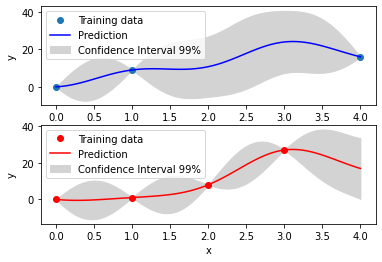

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from smt.surrogate_models import KRG
from smt.applications.mixed_integer import MixedIntegerSurrogateModel, ENUM,ORD,FLOAT,GOWER, HOMO_GAUSSIAN

xt1 = np.array([[0,0.0],
               [0,1.0],
               [0,4.0]])
xt2 = np.array([[1,0.0],
               [1,1.0],
               [1,2.0],
               [1,3.0]])
xt = np.concatenate((xt1, xt2), axis=0)
xt[:,1] = xt[:,1].astype(np.float) 
yt1 = np.array([0.0, 9.0, 16.0])
yt2 = np.array([ 0.0, 1.0,8.0,27.0])
yt = np.concatenate((yt1, yt2), axis=0)
xlimits =  [["Blue","Red"],[0.0,4.0]]
xtypes=[(ENUM, 2),FLOAT]
# Surrogate
sm = MixedIntegerSurrogateModel(categorical_kernel = HOMO_GAUSSIAN, xtypes=xtypes, xlimits=xlimits, surrogate=KRG(theta0=[1e-2]))
sm.set_training_values(xt, yt)
sm.train()

# DOE for validation
n = 100
x_cat1 = []
x_cat2 = []
for i in range(n):
    x_cat1.append(0)
    x_cat2.append(1)

x_cont = np.linspace(0.0, 4.0, n)
x1 = np.concatenate((np.asarray(x_cat1).reshape(-1,1), x_cont.reshape(-1,1)), axis=1)
x2 = np.concatenate((np.asarray(x_cat2).reshape(-1,1), x_cont.reshape(-1,1)), axis=1) 

y1 = sm.predict_values(x1)
y2 = sm.predict_values(x2)

# estimated variance
s2_1 = sm.predict_variances(x1)
s2_2 = sm.predict_variances(x2)

fig, axs = plt.subplots(2)
axs[0].plot(xt1[:,1].astype(np.float), yt1,'o',linestyle="None")
axs[0].plot(x_cont, y1,color ='Blue')
axs[0].fill_between(
    np.ravel(x_cont),
    np.ravel(y1 - 3 * np.sqrt(s2_1)),
    np.ravel(y1 + 3 * np.sqrt(s2_1)),
    color="lightgrey",
)
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].legend(
    ["Training data", "Prediction", "Confidence Interval 99%"],
    loc="upper left",
)
axs[1].plot(xt2[:,1].astype(np.float), yt2, marker='o', color='r',linestyle="None")
axs[1].plot(x_cont, y2,color ='Red')
axs[1].fill_between(
    np.ravel(x_cont),
    np.ravel(y2 - 3 * np.sqrt(s2_2)),
    np.ravel(y2 + 3 * np.sqrt(s2_2)),
    color="lightgrey",
)
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].legend(
    ["Training data", "Prediction", "Confidence Interval 99%"],
    loc="upper left",
)

plt.show()

### Gower mixed based optimization 4D function 

Initial DOE: 
 xdoe =  [[ 1.          1.          0.          1.70295015]
 [ 2.          1.          2.         -2.1809854 ]] 
 ydoe =  [ 3.23560529 -4.2158084 ]


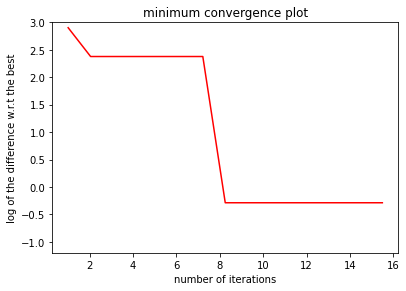

In [ ]:
#to define the 4D function 
def function_test_mixed_integer(X):
    import numpy as np

    # float
    x1 = X[:, 3]
    #  enum 1
    c1 = X[:, 0]
    x2 = c1 == 0
    x3 = c1 == 1
    x4 = c1 == 2
    #  enum 2
    c2 = X[:, 1]
    x5 = c2 == 0
    x6 = c2 == 1
    # int
    i = X[:, 2]

    y = (
        (x2 + 2 * x3 + 3 * x4) * x5 * x1
        + (x2 + 2 * x3 + 3 * x4) * x6 * 0.95 * x1
        + i
    )
    return y
#to run the optimization process
n_iter = 15
xtypes = [(ENUM, 3), (ENUM, 2), ORD,FLOAT]
xlimits = np.array([["blue", "red", "green"], ["large", "small"], ["0","1","2"],[-5, 5]])
criterion = "EI"  #'EI' or 'SBO' or 'LCB'
qEI = "KB"
sm = KRG(print_global=False)

n_doe = 2
sampling = MixedIntegerSamplingMethod(xtypes, xlimits, LHS, criterion="ese")
xdoe = sampling(n_doe)
ydoe = function_test_mixed_integer(xdoe)
print('Initial DOE: \n', 'xdoe = ',xdoe, '\n ydoe = ',ydoe)

ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    ydoe=ydoe,
    xtypes=xtypes,
    xlimits=xlimits,
    surrogate=sm,
    qEI=qEI,
    categorical_kernel= GOWER,
)

x_opt,y_opt, _, _, y_data = ego.optimize(fun=function_test_mixed_integer)

#to plot the objective function during the optimization process
min_ref = -15
mini = np.zeros(n_iter)
for k in range(n_iter):
    mini[k] = np.log(np.abs(np.min(y_data[0 : k + n_doe - 1]) - min_ref))
x_plot = np.linspace(1, n_iter + 0.5, n_iter)
u = max(np.floor(max(mini)) + 1, -100)
l = max(np.floor(min(mini)) - 0.2, -10)
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(x_plot, mini, color="r")
axes.set_ylim([l, u])
plt.title("minimum convergence plot", loc="center")
plt.xlabel("number of iterations")
plt.ylabel("log of the difference w.r.t the best")
plt.show()



In [ ]:
print(" 4D EGO Optimization: Minimum in x=",cast_to_mixed_integer(xtypes, xlimits, x_opt), "with y value =",y_opt)

 4D EGO Optimization: Minimum in x= ['green', 'small', 0, -5.0] with y value = [-14.25]


### Group kernel mixed based optimization 4D function 

There is two distinct models : the homoscedastic one (HOMO_GAUSSIAN) that does not considerer different variances between the variables and the heteroscedastic one (HETERO_GAUSSIAN)

For mixed integer with Group kernels, the reference thesis is available here https://hal.inria.fr/tel-03113542/document

Initial DOE: 
 xdoe =  [[ 1.          0.          1.         -3.44206638]
 [ 2.          1.          2.          3.22796094]] 
 ydoe =  [-5.88413276 11.19968868]


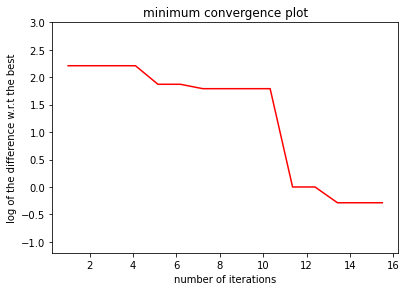

In [ ]:
#to define the 4D function 
def function_test_mixed_integer(X):
    import numpy as np

    # float
    x1 = X[:, 3]
    #  enum 1
    c1 = X[:, 0]
    x2 = c1 == 0
    x3 = c1 == 1
    x4 = c1 == 2
    #  enum 2
    c2 = X[:, 1]
    x5 = c2 == 0
    x6 = c2 == 1
    # int
    i = X[:, 2]

    y = (
        (x2 + 2 * x3 + 3 * x4) * x5 * x1
        + (x2 + 2 * x3 + 3 * x4) * x6 * 0.95 * x1
        + i
    )
    return y
#to run the optimization process
n_iter = 15
xtypes = [(ENUM, 3), (ENUM, 2), ORD,FLOAT]
xlimits = np.array([["blue", "red", "green"], ["large", "small"], ["0","1","2"],[-5, 5]])
criterion = "EI"  #'EI' or 'SBO' or 'LCB'
qEI = "KB"
sm = KRG(print_global=False)

n_doe = 2
sampling = MixedIntegerSamplingMethod(xtypes, xlimits, LHS, criterion="ese")
xdoe = sampling(n_doe)
ydoe = function_test_mixed_integer(xdoe)
print('Initial DOE: \n', 'xdoe = ',xdoe, '\n ydoe = ',ydoe)

ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    ydoe=ydoe,
    xtypes=xtypes,
    xlimits=xlimits,
    surrogate=sm,
    qEI=qEI,
    categorical_kernel= HOMO_GAUSSIAN,
)

x_opt,y_opt, _, _, y_data = ego.optimize(fun=function_test_mixed_integer)

#to plot the objective function during the optimization process
min_ref = -15
mini = np.zeros(n_iter)
for k in range(n_iter):
    mini[k] = np.log(np.abs(np.min(y_data[0 : k + n_doe - 1]) - min_ref))
x_plot = np.linspace(1, n_iter + 0.5, n_iter)
u = max(np.floor(max(mini)) + 1, -100)
l = max(np.floor(min(mini)) - 0.2, -10)
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(x_plot, mini, color="r")
axes.set_ylim([l, u])
plt.title("minimum convergence plot", loc="center")
plt.xlabel("number of iterations")
plt.ylabel("log of the difference w.r.t the best")
plt.show()



In [ ]:
print(" 4D EGO Optimization: Minimum in x=",cast_to_mixed_integer(xtypes, xlimits, x_opt), "with y value =",y_opt)

 4D EGO Optimization: Minimum in x= ['green', 'small', 0, -5.0] with y value = [-14.25]


## MoE Example 1

MOE Experts:  ['KRG', 'KPLS', 'KPLSK', 'LS', 'QP', 'RBF', 'IDW', 'RMTB', 'RMTC']
MOE1 enabled experts:  ['KRG', 'LS', 'QP', 'KPLS', 'KPLSK', 'RBF', 'RMTC', 'RMTB', 'IDW']
Kriging 1.8262207885868436
LS 3.292686966240607
QP 2.5146162179490354
KPLS 1.826220788586988
KPLSK 1.8262207885868436
RBF 1.8121733868939065
RMTC 0.7218170326354906
RMTB 0.7262718847440128
IDW 0.5249547613845662
Best expert = IDW
MOE2 enabled experts:  ['KRG', 'LS', 'IDW']
Kriging 0.0034813824710443475
LS 0.14196607571546527
IDW 0.2265170533613058
Best expert = Kriging
Kriging 7.751456963840146e-07
LS 4.440892098500626e-16
IDW 0.13389238051164326
Best expert = LS
Kriging 6.828223517718263e-07
LS 0.026711170330602847
IDW 0.0071340980233521355
Best expert = Kriging


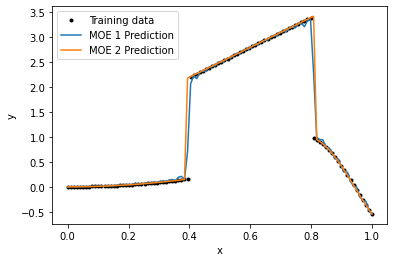

In [36]:
import numpy as np
from smt.applications import MOE
from smt.sampling_methods import FullFactorial
import matplotlib.pyplot as plt

ndim = 1
nt = 35

def function_test_1d(x):
    import numpy as np  # Note: only required by SMT doc testing toolchain

    x = np.reshape(x, (-1,))
    y = np.zeros(x.shape)
    y[x < 0.4] = x[x < 0.4] ** 2
    y[(x >= 0.4) & (x < 0.8)] = 3 * x[(x >= 0.4) & (x < 0.8)] + 1
    y[x >= 0.8] = np.sin(10 * x[x >= 0.8])
    return y.reshape((-1, 1))

x = np.linspace(0, 1, 100)
ytrue = function_test_1d(x)

# Training data
sampling = FullFactorial(xlimits=np.array([[0, 1]]), clip=True)
np.random.seed(0)
xt = sampling(nt)
yt = function_test_1d(xt)

# Mixture of experts
print("MOE Experts: ", MOE.AVAILABLE_EXPERTS)

# MOE1: Find the best surrogate model on the whole domain
moe1 = MOE(n_clusters=1)
print("MOE1 enabled experts: ", moe1.enabled_experts)
moe1.set_training_values(xt, yt)
moe1.train()
y_moe1 = moe1.predict_values(x)

# MOE2: Set nb of cluster with just KRG, LS and IDW surrogate models
moe2 = MOE(smooth_recombination=False, n_clusters=3, allow=["KRG", "LS", "IDW"])
print("MOE2 enabled experts: ", moe2.enabled_experts)
moe2.set_training_values(xt, yt)
moe2.train()
y_moe2 = moe2.predict_values(x)

fig, axs = plt.subplots(1)
axs.plot(x, ytrue, ".", color="black")
axs.plot(x, y_moe1)
axs.plot(x, y_moe2)
axs.set_xlabel("x")
axs.set_ylabel("y")
axs.legend(["Training data", "MOE 1 Prediction", "MOE 2 Prediction"])

plt.show()

## MoE Example 2

MOE Experts:  ['KRG', 'KPLS', 'KPLSK', 'LS', 'QP', 'RBF', 'IDW', 'RMTB', 'RMTC']
Enabled Experts:  ['KRG', 'LS', 'QP', 'KPLS', 'RBF', 'RMTC', 'IDW']
Kriging 0.0023722649659382957
LS 0.08549097550453036
QP 0.009464171715294224
KPLS 0.0021817023723960886
RBF 0.002729672213919944
RMTC 0.027231589795527693
IDW 0.23021994606780438
Best expert = KPLS
Kriging 0.0007900659115678381
LS 0.09110761266315685
QP 0.02610334864632158
KPLS 0.0008153969994144473
RBF 0.002142643776374767
RMTC 0.028446159082591994
IDW 0.16052339640158883
Best expert = Kriging
Kriging 0.0009629205215724391
LS 0.07083661007512043
QP 0.008991392622195872
KPLS 0.00422925201122476
RBF 0.0009524104504809807
RMTC 0.04517414379204437
IDW 0.23160779607143606
Best expert = RBF
Kriging 0.005892738215586647
LS 0.08289865595964081
QP 0.04584309268944308
KPLS 0.0062166163524031166
RBF 0.004776812954887922
RMTC 0.0481033277924318
IDW 0.2153214768235451
Best expert = RBF
Kriging 0.005713000038899284
LS 0.17335564441573936
QP 0.036110181

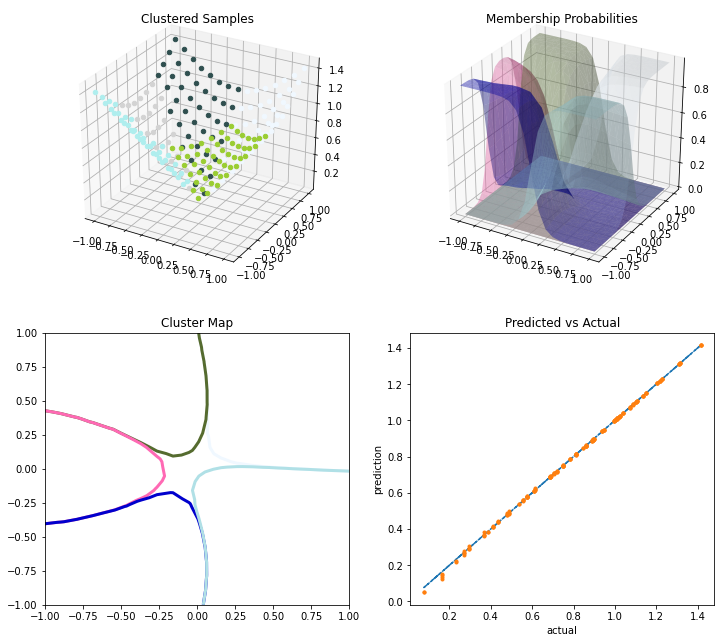

In [37]:
import numpy as np
from smt.applications import MOE
from smt.problems import LpNorm
from smt.sampling_methods import FullFactorial

import sklearn
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D

ndim = 2
nt = 200
ne = 200

# Problem: L1 norm (dimension 2)
prob = LpNorm(ndim=ndim)

# Training data
sampling = FullFactorial(xlimits=prob.xlimits, clip=True)
np.random.seed(0)
xt = sampling(nt)
yt = prob(xt)

# Mixture of experts
print("MOE Experts: ", MOE.AVAILABLE_EXPERTS)

moe = MOE(smooth_recombination=True, n_clusters=5, deny=["RMTB", "KPLSK"])
print("Enabled Experts: ", moe.enabled_experts)
moe.set_training_values(xt, yt)
moe.train()

# Validation data
np.random.seed(1)
xe = sampling(ne)
ye = prob(xe)

# Prediction
y = moe.predict_values(xe)
fig = plt.figure(1)
fig.set_size_inches(12, 11)

# Cluster display
colors_ = list(colors.cnames.items())
GMM = moe.cluster
weight = GMM.weights_
mean = GMM.means_
if sklearn.__version__ < "0.20.0":
    cov = GMM.covars_
else:
    cov = GMM.covariances_
prob_ = moe._proba_cluster(xt)
sort = np.apply_along_axis(np.argmax, 1, prob_)

xlim = prob.xlimits
x0 = np.linspace(xlim[0, 0], xlim[0, 1], 20)
x1 = np.linspace(xlim[1, 0], xlim[1, 1], 20)
xv, yv = np.meshgrid(x0, x1)
x = np.array(list(zip(xv.reshape((-1,)), yv.reshape((-1,)))))
prob = moe._proba_cluster(x)

plt.subplot(221, projection="3d")
ax = plt.gca()
for i in range(len(sort)):
    color = colors_[int(((len(colors_) - 1) / sort.max()) * sort[i])][0]
    ax.scatter(xt[i][0], xt[i][1], yt[i], c=color)
plt.title("Clustered Samples")

plt.subplot(222, projection="3d")
ax = plt.gca()
for i in range(len(weight)):
    color = colors_[int(((len(colors_) - 1) / len(weight)) * i)][0]
    ax.plot_trisurf(
        x[:, 0], x[:, 1], prob[:, i], alpha=0.4, linewidth=0, color=color
    )
plt.title("Membership Probabilities")

plt.subplot(223)
for i in range(len(weight)):
    color = colors_[int(((len(colors_) - 1) / len(weight)) * i)][0]
    plt.tricontour(x[:, 0], x[:, 1], prob[:, i], 1, colors=color, linewidths=3)
plt.title("Cluster Map")

plt.subplot(224)
plt.plot(ye, ye, "-.")
plt.plot(ye, y, ".")
plt.xlabel("actual")
plt.ylabel("prediction")
plt.title("Predicted vs Actual")

plt.show()
